In [9]:
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
%matplotlib inline
from matplotlib.ticker import FuncFormatter 
import matplotlib
import matplotlib.pyplot as plt
import glob
from pdb import set_trace
import json
import numpy as np
from scipy.stats import stats

game_titles = {
        "shuffleKeys_game": "Shuffle Keys Game",
        "contingency_game": "Contingency Game",
        "logic_game": "Logic Game"
    }

def ts_plotter(self, ax, data1, data2):
    '''
    Helper for plotting panels in time series plot.
    '''

    out = ax.plot(data1, data2, linewidth=2)
    return out   

def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def plot_performance(game_types, agent_types, dqn_types, y_lims):
    ''' Plot performance for games and agents'''
    
    param_dict = {}   

    ## ----- Read in data
    for i, game_type in enumerate(game_types):
        param_dict[game_type] = {}
        for agent_type in agent_types:
            if agent_type == 'dqn_training':
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/" + dqn_types[i] + "/*.json")
            else:
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")
            param_dict[game_type][agent_type] = {}
            for file in files:
                with open (file, 'r') as fp: 
                    data = json.load(fp)
                    if agent_type == 'dqn_training':
                        param_dict[game_type][agent_type][file.split('/')[5].split('.json')[0]] = data['data']['steps']
                    else:
                        param_dict[game_type][agent_type][file.split('/')[4].split('.json')[0]] = data['data']['steps']
    

    ## ---- Get descriptive statistics
    stats_dict = {}
    for game_type in game_types:
        stats_dict[game_type] = {} 
        for agent_type in agent_types:
            curr_data = pd.DataFrame(param_dict[game_type][agent_type])
            stats_dict[game_type][agent_type + "_m"] = curr_data.mean(axis=1) 
            stats_dict[game_type][agent_type + "_se"] = curr_data.sem(axis=1)

    stats_dict['x'] = [i for i in range(0, len(stats_dict[game_type][agent_type + "_m"]))]  
    
    ## Run this cell if you want to bin the data
    #stats = stats.groupby(stats.index // 5).mean().reset_index()
    #stats['x'] = stats.index
    
    ## ---- Plot data
    plotter(stats_dict, game_types, agent_types, y_lims)

def plotter(stats, game_types, agent_types, y_lims):
    for i, game_type in enumerate(game_types):
        st = stats[game_type]

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_ylim([0, y_lims[i]]) #13 or 150
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="No. of Steps to Complete Level", labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        ax.set_title( game_titles[game_type], fontweight='bold', fontsize=15 )

        # Random policy
        r_l = ax.plot(st['random_m'], color='gray', linewidth=1, label='Random')
        ax.fill_between(stats['x'], st['random_m'] - st['random_se'], st['random_m'] + st['random_se'], alpha=0.08, color='gray')

        # DQN 
        dqn_l = ax.plot(st['dqn_training_m'], color='orange', linewidth=2, label='DQN')
        ax.fill_between(stats['x'], st['dqn_training_m'] - st['dqn_training_se'], st['dqn_training_m'] + st['dqn_training_se'], alpha=0.08, color='orange')

        # Self class
        sc_l = ax.plot(st['self_class_m'], color='blue', linewidth=2, label='Self Class')
        ax.fill_between(stats['x'], st['self_class_m'] - st['self_class_se'], st['self_class_m'] + st['self_class_se'], alpha=0.08, color='blue')

        # Humans
        hum_l = ax.plot(st['human_m'], color='red', linewidth=2, label='Humans')
        ax.fill_between(stats['x'], st['human_m'] - st['human_se'], st['human_m'] + st['human_se'], alpha=0.08, color='red')

        #first_legend = plt.legend(handles=[r_l[0], dqn_l[0], sc_l[0], hum_l[0]], loc='upper right', prop={'size': 22})
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        fig.savefig('effiency_curves.pdf', format='pdf')
    

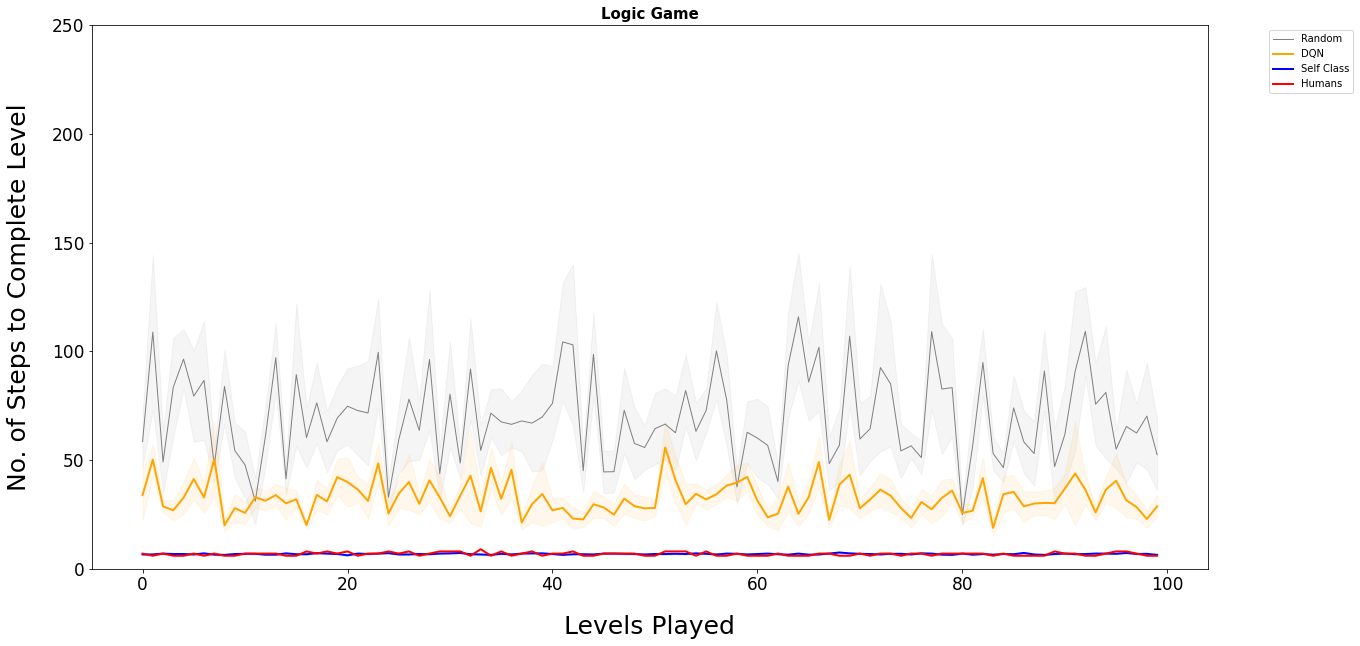

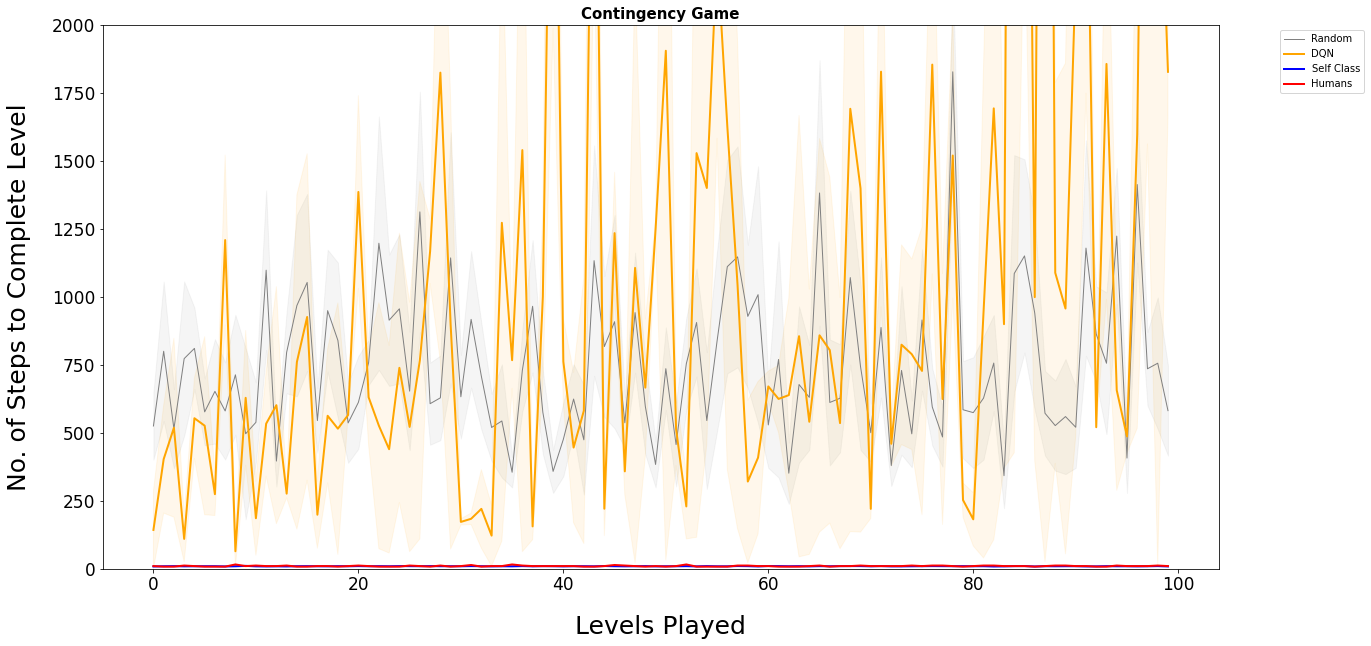

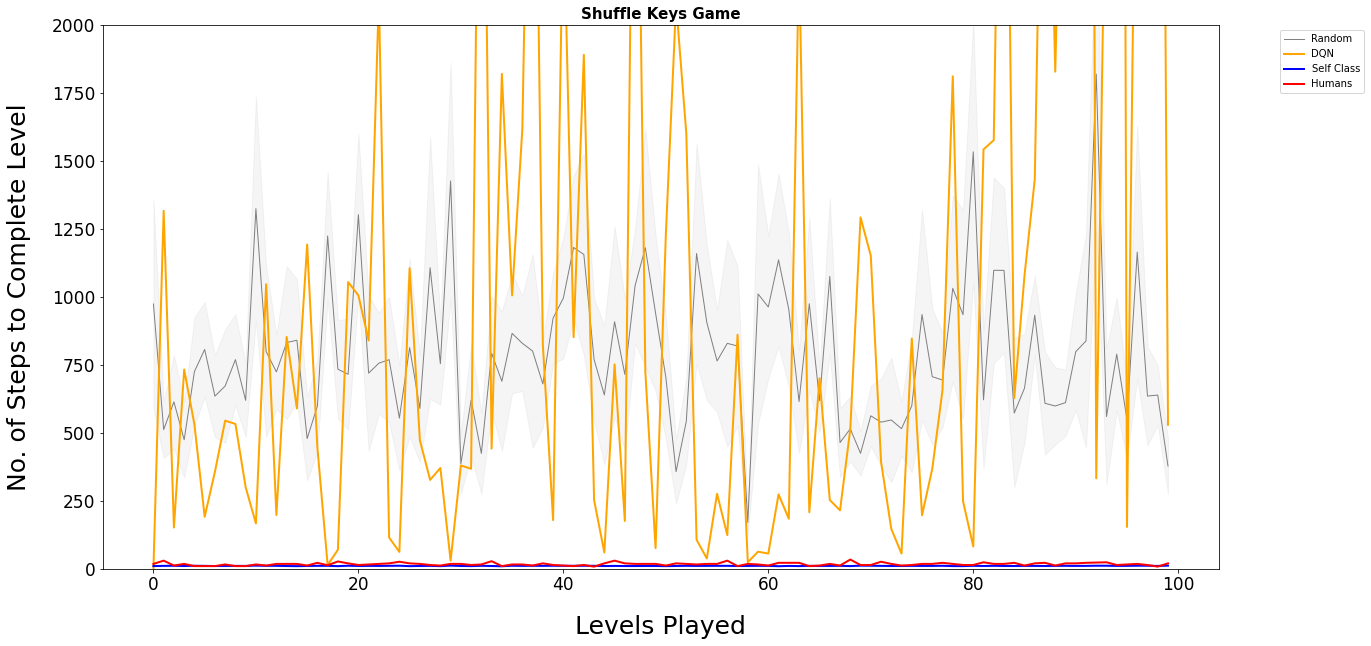

In [11]:
game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
agent_types = ["dqn_training", "human", "random", "self_class"]
dqn_types = ['lr.0001_y.7', 'lr.0001_y.7', 'lr.0001_y.7']
y_lims = [250, 2000, 2000]
plot_performance(game_types, agent_types, dqn_types, y_lims)

In [12]:
## ----- Deeper dive into different DQN hyperparameters
def plot_dqns(directory, y_lims):

    param_folders = glob.glob(directory)
    param_dict = {}   
    ## ----- Read in data
    for folder in param_folders:
        folder_name = folder.split('/')[4]
        param_dict[folder_name] = {}
        files = glob.glob(folder + "/*.json")
        for file in files:
            with open (file, 'r') as fp: 
                data = json.load(fp)
                param_dict[folder_name][file.split('/')[5].split('.json')[0]] = data['data']['steps']

    ## ---- Get descriptive statistics
    stats2 = pd.DataFrame() #for stats
    stats2_keys = []
    for key in param_dict:
        curr_data = pd.DataFrame(param_dict[key])
        stats2[key + "_m"] = curr_data.mean(axis=1)
        stats2[key + "_se"] = curr_data.sem(axis=1)
        stats2_keys.append(key)

    stats2['x'] = [i for i in range(0, len(stats2[key + "_m"]))]   
    
    plotter2(stats2, y_lims, stats2_keys)
    
def plotter2(stats2, y_lims, stats2_keys):
        ## --- Plot descriptive statistics
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_ylim([0, 6000]) #13 or 150
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="No. of Steps to Complete Level", labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)

        #colors = ['orange', 'blue', 'red', 'purple']
        colors = []
        handle_list = []

        key_counter = -1
        for key in stats2_keys:
            key_counter += 1
            #colors[key_counter] = random_color()
            handle = ax.plot(stats2[key + "_m"], linewidth=2, label=str(key))
            handle_list.append(handle[0])
            ax.fill_between(stats2['x'], stats2[key+"_m"] - stats2[key+"_se"], stats2[key+"_m"] + stats2[key+"_se"], alpha=0.08)

#        first_legend = plt.legend(handles=handle_list, loc='upper right', prop={'size': 22})    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

        ## --- Bin data
        #stats_2 = stats_2.groupby(stats_2.index // 5).mean().reset_index()
        #stats_2['x'] = stats_2.index

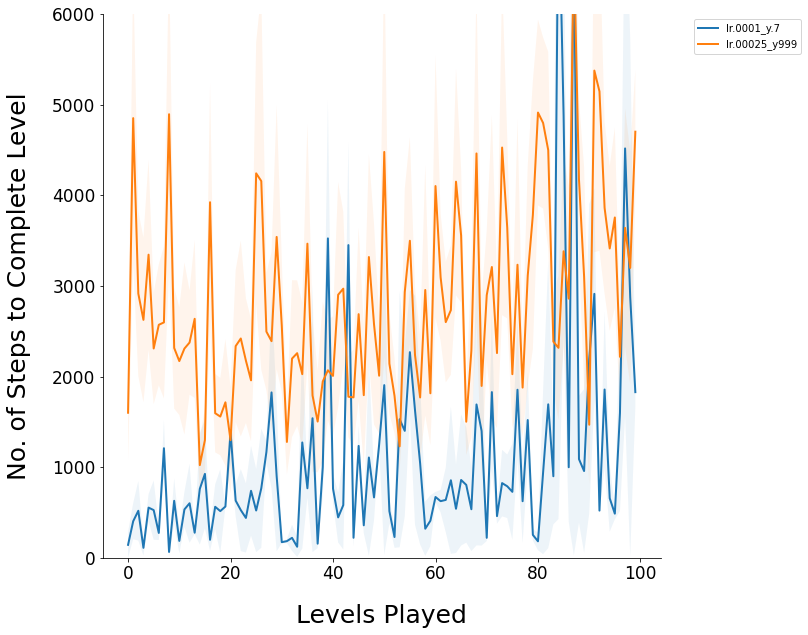

In [13]:
directory = "../data/contingency_game/dqn_training/*"
#game_types = ["logic_game", "contingency_game", "shuffleKeys_game"]
y_lims = [250, 2000, 2000]
plot_dqns(directory, y_lims)

In [14]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot non-moving action count of agent for each level
def plot_nm_ac(game_types):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac()

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_ylim([0, 10])
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="Action Count Until Self Discovery", labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        game_label_dict = {'logic_game': "Logic Game"}
        ax.set_title( game_label_dict[game_type], fontweight='bold', fontsize=15 )
        x = [i for i in range(0, len(nm_ac["random_m"]))]
        
        colors = ['gray', 'orange', 'blue', 'red']
        agent_label_dict = {'dqn_training': 'DQN', 'human':"Human", "self_class": "Self Class", "random": "Random"}
        for j, agent in enumerate(agent_types):
            ax.plot( nm_ac[agent + "_m"], color=colors[j], linewidth=1, label=agent_label_dict[agent] )
            upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
            lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
            ax.fill_between( x, lower_curve, upper_curve, alpha=0.08, color=colors[j] )

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
        fig.savefig('non_moving_ac_curves.pdf', format='pdf')

# # Get non-moving action count of agent for each level and each game as a dictionary
def get_all_nm_ac():
    agent_types = ["dqn_training", "human", "random", "self_class"]

    stats = {}
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"] = get_nm_ac(agent)
        
    return stats

# Get non-moving action count of agent for each level
def get_nm_ac(agent_type):
    files = glob.glob("../data/logic_game/" + agent_type + "/*.json")

    if agent_type == "dqn_training":
        files = glob.glob("../data/logic_game/" + agent_type + "/*/*.json") # if DQN, select all types

    seed_counts = []
    for file in files:
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = len( data.get("data")["level"] )
        level_count = [1] * level_amt
        seed_counts.append(level_count)

        # iterate through each action and find action amt done until movement
        for level in range(level_amt):
            if len( self_locs[level] ) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range( action_amt ):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if (x != x1) or (y != y1): # if position is changed
                    break
                else:
                    level_count[level] = level_count[level] + 1

    # Get average of each seed
    seed_mean = [0] * len(seed_counts[0]) # level amt

    # take transpose of level_count, to find sem
    numpy_array = np.array(seed_counts)
    transpose = numpy_array.T
    transpose_list = transpose.tolist()
    s_sem = []
    for i in range(len(transpose_list)):
        s_sem.append( stats.sem(transpose_list[i], axis=None, ddof=0) )

    for level in range( len(seed_counts[0]) ): # level amt
        for seed in range( len(seed_counts) ):
            seed_mean[level] += seed_counts[seed][level] # sum of each level at each seed
        seed_mean[level] = float( seed_mean[level] ) / len(seed_counts) # get mean

    return seed_mean, s_sem

smean, ssem = get_nm_ac("random")

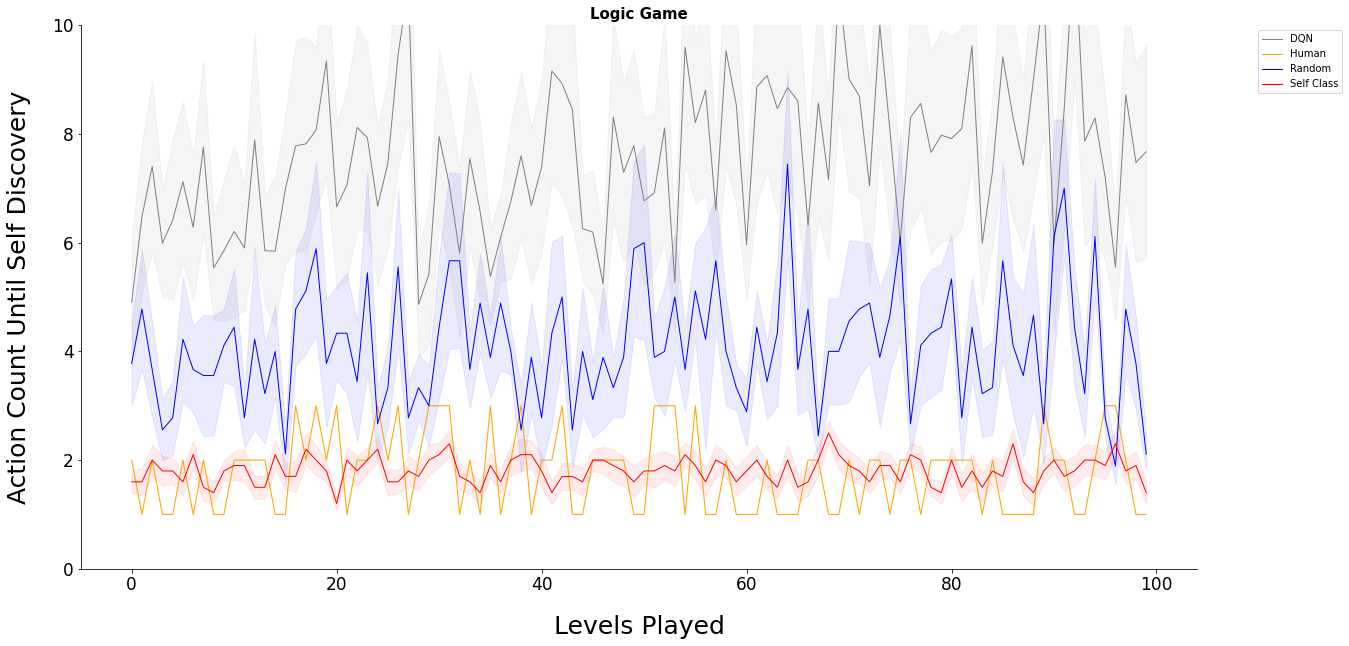

In [15]:
game_types = ["logic_game"]
plot_nm_ac(game_types)
